# Imports

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Tuple, Union, Sequence

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import PIL


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm
import json

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/urothel_ca')
PATH_WSIS = PATH/'Neue_Scans_Urothelkarzinome'
#PATH_ROIS = PATH/'Rois_Christoph'
PATH_ROIS = PATH/'Rois_Samir'
PATH_ROIS_ADJUSTED = PATH/'Rois_Samir_adjusted'
PATH_EXCEL_SHEET = PATH/'Data_Sheet_MIER_22112021.xlsx'


seed = 42
np.random.seed(seed)

# Data 

In [18]:
wsi_mrxs_paths = [p for p in PATH_WSIS.ls() if p.suffix == '.mrxs']
len(wsi_mrxs_paths)

239

In [19]:
wsi_dir_paths = [p for p in PATH_WSIS.ls() if p.suffix == '']
len(wsi_dir_paths)

239

In [20]:
json_paths = PATH_ROIS.ls()
len(json_paths)

233

## get rois for each wsi path

### wsi path to json file mapping

In [21]:
def find_json_path(mrxs_path:pathlib.Path)->pathlib.Path:
    stem = mrxs_path.stem
    for jp in json_paths:
        if(jp.stem == stem):
            return jp
    return None

In [22]:
wsi_mrxs_to_json_path = {}
wsi_mrxs_paths_without_corresponding_json_file = []
for mrxs_p in wsi_mrxs_paths:
    jp = find_json_path(mrxs_path=mrxs_p)
    if(jp is not None):
        wsi_mrxs_to_json_path[mrxs_p] = jp
    else:
        wsi_mrxs_paths_without_corresponding_json_file.append(mrxs_p)

In [23]:
len(wsi_mrxs_to_json_path)

233

In [24]:
len(wsi_mrxs_paths_without_corresponding_json_file)

6

### custom function that creates PolygonHelper objects from a given json file with the roi coordinates

In [25]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]]):
        self.level = level
        self.vertices = vertices

def get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            #skip rois that are not classified as Tumor
            if(annotation["properties"]["classification"]["name"] == "Tumor"):
                if(annotation["geometry"]["type"] == 'MultiPolygon'):
                    multi_polygon_vertices = annotation["geometry"]["coordinates"]
                    #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                    ##QuPath produces Polygons and Multipolygons 
                    ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                    ##multipolygon-for-shapefiles-in-qgis/225373)
                    ##This loop separates Multipolygons into individual Polygons
                    for sub_polygon_vertices in multi_polygon_vertices:
                        sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                        if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                            #print(f'/1/: {sub_polygon_vertices_array.shape}')
                            polygons.append(__PolygonHelper(level=0, vertices=sub_polygon_vertices_array))
                        else:
                            for elem in sub_polygon_vertices_array:
                                elem_array = np.array(elem).squeeze()
                                #print(f'/2/: {elem_array.shape}')
                                polygons.append(__PolygonHelper(level=0, vertices=elem_array))
                    
                elif(annotation["geometry"]["type"] == 'Polygon'):
                    vertices = annotation["geometry"]["coordinates"]
                    #print(f'/3/ len of vertices: {len(vertices)}')
                    for ls in vertices:               
                        #print(f'/4/: {np.array(ls).squeeze().shape}')
                        polygons.append(__PolygonHelper(level=0, vertices=np.array(ls, dtype=object).squeeze()))
                else:
                    assert False
    return polygons

### adjust misalligned rois because of black and white padding when mrxs files are opened by openslide

In [26]:
def is_row_black(img:Union[PIL.Image.Image, numpy.ndarray], row_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[row_num, :, :] == [0,0,0])

def is_column_black(img:Union[PIL.Image.Image, numpy.ndarray], column_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[:, column_num, :] == [0,0,0])

def get_num_of_black_rows_at_top(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_rows = 0
    while(is_row_black(img=img, row_num=n_rows)):
        n_rows += 1
    return n_rows

def get_num_of_black_columns_at_left(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_columns = 0
    while(is_column_black(img=img, column_num=n_columns)):
        n_columns += 1
    return n_columns

class Row_or_col(Enum):
    ROW = 1
    COLUMN = 2
    
def is_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], index:int, row_or_col:Row_or_col)->bool:
    """
    checks if the by index specified row or column in the image contains only [0,0,0] == black
    or [255,255,255] == white RGB values
    """
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    a = None
    if(row_or_col is Row_or_col.ROW):
        a = img[index, :, :]
    elif(row_or_col is Row_or_col.COLUMN):
        a = img[:, index, :]
    else:
        raise ValueError('row_or_col has insufficient value')
    return np.where(np.logical_and(np.ravel(a) > 0, np.ravel(a) < 255))[0].size == 0

def get_num_of_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], row_or_col:Row_or_col)->int:
    n = 0
    while(is_only_black_white(img=img, index=n, row_or_col=row_or_col)):
        n += 1
    return n

def adjust_rois(wsi_img:Union[PIL.Image.Image, numpy.ndarray], 
                wsi_img_level:int, 
                rois:List[roi.RegionOfInterestPolygon]):
    """
    returns new RegionOfInterestPolygon objects
    """
    cols_left = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.COLUMN)
    rows_top = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.ROW)
    rois_adjusted = []
    for r in rois:
        new_vertices = util.polygon_to_numpy(r.polygon)
        new_vertices += [util.adjust_level(value_to_adjust=cols_left, from_level=wsi_img_level, to_level=r.level), 
                         util.adjust_level(value_to_adjust=rows_top, from_level=wsi_img_level, to_level=r.level)]
        r_new = roi.RegionOfInterestPolygon(roi_id=r.roi_id, vertices=new_vertices, level=r.level)
        rois_adjusted.append(r_new)

    return rois_adjusted

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def adjust_and_save_rois(wsi_path, json_path):
    print(f'wsi: {wsi_path.name}')
    print(f'json: {json_path.name}')
        
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    if(not save_path.exists()):    
        wh = tiles.WsiHandler(wsi_path=wsi_path)
        rois = roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                        polygons_from_json_func=get_polygons_from_json)       
        rois_adjusted = adjust_rois(wsi_img=wh.get_wsi_as_pil_image(level=5), wsi_img_level=5, rois=rois)               
        save_as_pickle(rois_adjusted, save_path)
    else:
        print(f'Already exists: {save_path}')    

In [27]:
failed = []
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    try:
        roi.adjust_and_save_rois(wsi_path, json_path)
    except:
        failed.append(wsi_path)

100%|██████████| 233/233 [00:00<00:00, 380261.80it/s]


In [28]:
#no stroma rois
wsi_path_to_rois = {}
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    wsi_path_to_rois[wsi_path] = rois

100%|██████████| 233/233 [00:14<00:00, 16.13it/s]


## id and label funcs

In [29]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    split = wsi_path.stem.split('_')
    return f'{split[0]}_{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    tma_nr = wsi_path.stem.split('_')[1]
    row = data_sheet.iloc[int(tma_nr)-1]
    histology = row['Histology']
    variant_histology = row['Variant Histology']
    return [histology, variant_histology]

## tiles

In [30]:
tilesummaries_save_path = Path(f'./tilesummaries/001/')
tilesummaries = []

tilesummaries_saved_names = [p.stem for p in tilesummaries_save_path.ls()]

for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
#for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
    if(f'{wsi_path.stem}_tilesummary' in tilesummaries_saved_names):
        print(f'{wsi_path.stem} is loaded ...')
        tilesummaries.append(load_pickle(tilesummaries_save_path/f'{wsi_path.stem}_tilesummary.pickle'))
        pass
    else:
        print(f'{wsi_path.stem} tiles are calculated ...')    
        t = tiles.WsisToTilesParallel(wsi_paths=[wsi_path],
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_1,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.95, 
                                          verbose=True, 
                                          grids_per_roi=1, 
                                          optimize_grid_angles=False)[0]
        tilesummaries.append(t)
        p = tilesummaries_save_path/f'{t.wsi_path.stem}_tilesummary.pickle'
        save_as_pickle(t, p)

  1%|          | 2/233 [00:00<00:18, 12.68it/s]

MIER_140_M17 is loaded ...
MIER_151_M3 is loaded ...
MIER_158_TUR2 is loaded ...


  1%|▏         | 3/233 [00:00<00:21, 10.78it/s]

MIER_175_M12 is loaded ...
MIER_200_M9 is loaded ...
MIER_211_C is loaded ...


  4%|▍         | 9/233 [00:00<00:17, 12.76it/s]

MIER_217_C is loaded ...
MIER_236_C is loaded ...
MIER_40_D is loaded ...
MIER_52_B is loaded ...


  5%|▍         | 11/233 [00:00<00:21, 10.38it/s]

MIER_74_M10 is loaded ...
MIER_184_I is loaded ...


  5%|▌         | 12/233 [00:01<00:26,  8.25it/s]

MIER_46_A is loaded ...


  6%|▌         | 14/233 [00:01<00:34,  6.33it/s]

MIER_134_TUR1 is loaded ...
MIER_130_C is loaded ...


  7%|▋         | 16/233 [00:01<00:32,  6.68it/s]

MIER_233_TUR1 is loaded ...
MIER_127_G is loaded ...
MIER_41_A is loaded ...
MIER_115_C is loaded ...


  9%|▉         | 22/233 [00:02<00:20, 10.23it/s]

MIER_147_A is loaded ...
MIER_17_C is loaded ...
MIER_183_A is loaded ...
MIER_222_M13 is loaded ...
MIER_50_A is loaded ...


 11%|█         | 26/233 [00:02<00:22,  9.07it/s]

MIER_79_D is loaded ...
MIER_167_L is loaded ...
MIER_187_M13 is loaded ...
MIER_145_B is loaded ...


 12%|█▏        | 29/233 [00:02<00:19, 10.57it/s]

MIER_71_H is loaded ...
MIER_6_C is loaded ...


 13%|█▎        | 31/233 [00:03<00:26,  7.52it/s]

MIER_229_TUR2 is loaded ...
MIER_154_M21 is loaded ...
MIER_8_B is loaded ...


 14%|█▍        | 33/233 [00:03<00:24,  8.04it/s]

MIER_36_A is loaded ...
MIER_22_E is loaded ...


 15%|█▌        | 35/233 [00:03<00:24,  8.07it/s]

MIER_221_C is loaded ...
MIER_70_B is loaded ...


 16%|█▋        | 38/233 [00:04<00:26,  7.27it/s]

MIER_35_F is loaded ...
MIER_142_M13 is loaded ...
MIER_29_C is loaded ...
MIER_164_C is loaded ...


 19%|█▉        | 44/233 [00:04<00:17, 10.68it/s]

MIER_225_G is loaded ...
MIER_131_B is loaded ...
MIER_91_C is loaded ...
MIER_13_C is loaded ...


 21%|██        | 49/233 [00:04<00:16, 11.24it/s]

MIER_14_A is loaded ...
MIER_201_B is loaded ...
MIER_110_TUR3 is loaded ...
MIER_117_E is loaded ...
MIER_202_G is loaded ...


 22%|██▏       | 51/233 [00:05<00:14, 12.32it/s]

MIER_182_TUR4 is loaded ...
MIER_161_B is loaded ...
MIER_107_M22 is loaded ...
MIER_51_C is loaded ...


 23%|██▎       | 54/233 [00:05<00:14, 12.77it/s]

MIER_82_TUR1 is loaded ...


 25%|██▌       | 59/233 [00:05<00:17,  9.76it/s]

MIER_95_B is loaded ...
MIER_237_M4 is loaded ...
MIER_23_G is loaded ...
MIER_199_M10 is loaded ...
MIER_15_B is loaded ...
MIER_16_B is loaded ...


 27%|██▋       | 63/233 [00:06<00:17,  9.92it/s]

MIER_26_B is loaded ...
MIER_75_B is loaded ...
MIER_85_M12 is loaded ...
MIER_156_M15 is loaded ...


 29%|██▉       | 68/233 [00:06<00:13, 12.41it/s]

MIER_189_TUR is loaded ...
MIER_170_TUR1 is loaded ...
MIER_196_D is loaded ...
MIER_190_D is loaded ...


 30%|███       | 71/233 [00:06<00:11, 14.25it/s]

MIER_144_TUR is loaded ...
MIER_206_M11 is loaded ...
MIER_128_C is loaded ...
MIER_195_A is loaded ...


 32%|███▏      | 75/233 [00:07<00:18,  8.41it/s]

MIER_223_TUR is loaded ...
MIER_11_A is loaded ...
MIER_125_B is loaded ...
MIER_109_A is loaded ...


 33%|███▎      | 77/233 [00:07<00:16,  9.21it/s]

MIER_112_TUR1 is loaded ...
MIER_108_J is loaded ...


 35%|███▍      | 81/233 [00:07<00:14, 10.79it/s]

MIER_169_TUR is loaded ...
MIER_101_TUR3 is loaded ...
MIER_235_C is loaded ...
MIER_241_M5 is loaded ...
MIER_39_D is loaded ...


 37%|███▋      | 87/233 [00:08<00:10, 14.53it/s]

MIER_100_B is loaded ...
MIER_136_A is loaded ...
MIER_218_A is loaded ...
MIER_244_A is loaded ...
MIER_193_TUR2 is loaded ...


 39%|███▉      | 91/233 [00:08<00:10, 13.93it/s]

MIER_162_TUR2 is loaded ...
MIER_7_E is loaded ...
MIER_4_A is loaded ...
MIER_73_B is loaded ...


 40%|███▉      | 93/233 [00:08<00:09, 14.29it/s]

MIER_28_E is loaded ...
MIER_3_D is loaded ...


 41%|████      | 95/233 [00:09<00:20,  6.82it/s]

MIER_168_M3 is loaded ...


 42%|████▏     | 99/233 [00:09<00:16,  8.06it/s]

MIER_133_B is loaded ...
MIER_163_M4 is loaded ...
MIER_62_A is loaded ...
MIER_242_TUR2 is loaded ...


 43%|████▎     | 101/233 [00:09<00:14,  9.40it/s]

MIER_63_M17 is loaded ...
MIER_57_M21 is loaded ...
MIER_58_C is loaded ...


 45%|████▌     | 106/233 [00:10<00:10, 12.34it/s]

MIER_231_M11 is loaded ...
MIER_150_M16 is loaded ...
MIER_213_C is loaded ...
MIER_116_A is loaded ...


 46%|████▋     | 108/233 [00:10<00:09, 12.91it/s]

MIER_234_TUR8 is loaded ...
MIER_137_D is loaded ...
MIER_111_TUR5 is loaded ...


 47%|████▋     | 110/233 [00:10<00:09, 13.18it/s]

MIER_56_M16 is loaded ...
MIER_68_TUR2 is loaded ...


 49%|████▉     | 114/233 [00:10<00:10, 10.90it/s]

MIER_103_B is loaded ...
MIER_105_F is loaded ...
MIER_113_M16 is loaded ...
MIER_185_TUR1 is loaded ...


 50%|█████     | 117/233 [00:11<00:10, 11.58it/s]

MIER_186_M10 is loaded ...
MIER_2_B is loaded ...


 51%|█████     | 119/233 [00:11<00:10, 10.45it/s]

MIER_207_E is loaded ...
MIER_226_A is loaded ...
MIER_228_A is loaded ...


 52%|█████▏    | 121/233 [00:11<00:09, 11.21it/s]

MIER_239_M1 is loaded ...
MIER_59_B is loaded ...


 53%|█████▎    | 123/233 [00:11<00:10, 10.16it/s]

MIER_83_M13 is loaded ...


 54%|█████▎    | 125/233 [00:12<00:21,  5.12it/s]

MIER_92_TUR2 is loaded ...
MIER_55_M11 is loaded ...
MIER_66_TUR1 is loaded ...


 55%|█████▌    | 129/233 [00:12<00:14,  7.37it/s]

MIER_138_TUR is loaded ...
MIER_34_B is loaded ...
MIER_37_A is loaded ...


 57%|█████▋    | 132/233 [00:13<00:11,  9.03it/s]

MIER_42_C is loaded ...
MIER_87_M15 is loaded ...
MIER_165_B is loaded ...
MIER_20_A is loaded ...


 58%|█████▊    | 136/233 [00:13<00:09, 10.18it/s]

MIER_238_TUR2 is loaded ...
MIER_209_M16 is loaded ...
MIER_114_M21 is loaded ...
MIER_33_C is loaded ...


 60%|█████▉    | 139/233 [00:13<00:07, 12.56it/s]

MIER_198_A is loaded ...
MIER_179_M13 is loaded ...
MIER_97_TUR1 is loaded ...
MIER_157_M2 is loaded ...


 62%|██████▏   | 144/233 [00:13<00:06, 13.53it/s]

MIER_141_F is loaded ...
MIER_177_TUR2 is loaded ...
MIER_18_A is loaded ...


 63%|██████▎   | 146/233 [00:14<00:08, 10.08it/s]

MIER_227_E is loaded ...
MIER_159_TUR4 is loaded ...
MIER_152_TUR2 is loaded ...
MIER_27_A is loaded ...
MIER_30_A is loaded ...


 65%|██████▌   | 152/233 [00:14<00:07, 11.45it/s]

MIER_230_M12 is loaded ...
MIER_60_G is loaded ...
MIER_9_B is loaded ...


 67%|██████▋   | 156/233 [00:15<00:07,  9.77it/s]

MIER_99_TUR1 is loaded ...
MIER_129_C is loaded ...
MIER_172_F is loaded ...
MIER_173_B is loaded ...
MIER_176_TUR is loaded ...
MIER_180_F is loaded ...


 69%|██████▉   | 161/233 [00:16<00:09,  7.53it/s]

MIER_215_M18 is loaded ...
MIER_219_A is loaded ...
MIER_246_C is loaded ...
MIER_38_G is loaded ...


 71%|███████   | 165/233 [00:16<00:07,  9.56it/s]

MIER_61_A is loaded ...
MIER_240_M16 is loaded ...
MIER_126_E is loaded ...


 72%|███████▏  | 167/233 [00:16<00:06, 10.66it/s]

MIER_174_D is loaded ...
MIER_203_M13 is loaded ...
MIER_10_A is loaded ...


 74%|███████▍  | 172/233 [00:17<00:06,  9.19it/s]

MIER_232_M10 is loaded ...
MIER_72_A is loaded ...
MIER_76_B is loaded ...
MIER_77_A is loaded ...


 76%|███████▌  | 176/233 [00:17<00:05, 11.40it/s]

MIER_102_D is loaded ...
MIER_32_A is loaded ...
MIER_84_TUR2 is loaded ...
MIER_245_TUR1 is loaded ...


 77%|███████▋  | 179/233 [00:17<00:04, 12.60it/s]

MIER_123_LK1 is loaded ...
MIER_192_D is loaded ...
MIER_67_M20 is loaded ...


 79%|███████▉  | 185/233 [00:17<00:02, 16.11it/s]

MIER_160_D is loaded ...
MIER_214_A is loaded ...
MIER_139_TUR is loaded ...
MIER_188_M14 is loaded ...
MIER_149_C is loaded ...
MIER_45_D is loaded ...


 81%|████████  | 189/233 [00:18<00:02, 14.98it/s]

MIER_143_TUR1 is loaded ...
MIER_224_TUR3 is loaded ...
MIER_69_TUR6 is loaded ...
MIER_88_M6 is loaded ...


 82%|████████▏ | 191/233 [00:18<00:02, 14.47it/s]

MIER_90_A is loaded ...
MIER_12_A is loaded ...
MIER_124_TUR4 is loaded ...


 84%|████████▍ | 196/233 [00:18<00:02, 14.59it/s]

MIER_171_M18 is loaded ...
MIER_19_B is loaded ...
MIER_208_TUR4 is loaded ...
MIER_21_A is loaded ...
MIER_243_TUR5 is loaded ...


 85%|████████▍ | 198/233 [00:18<00:02, 13.63it/s]

MIER_43_B is loaded ...
MIER_44_B is loaded ...


 86%|████████▌ | 200/233 [00:20<00:07,  4.46it/s]

MIER_48_A is loaded ...
MIER_96_M7 is loaded ...


 87%|████████▋ | 202/233 [00:20<00:05,  5.29it/s]

MIER_98_TUR2 is loaded ...
MIER_93_M9 is loaded ...


 88%|████████▊ | 206/233 [00:20<00:03,  7.56it/s]

MIER_155_A is loaded ...
MIER_191_M2 is loaded ...
MIER_216_TUR3 is loaded ...
MIER_220_D is loaded ...


 89%|████████▉ | 208/233 [00:20<00:02,  9.17it/s]

MIER_49_A is loaded ...
MIER_5_A is loaded ...


 90%|█████████ | 210/233 [00:20<00:02,  8.52it/s]

MIER_197_TUR1 is loaded ...


 91%|█████████ | 212/233 [00:21<00:02,  7.97it/s]

MIER_65_A is loaded ...
MIER_81_TUR1 is loaded ...
MIER_212_M10 is loaded ...


 93%|█████████▎| 216/233 [00:21<00:01, 10.04it/s]

MIER_146_B is loaded ...
MIER_181_M10 is loaded ...
MIER_24_B is loaded ...
MIER_247_M11 is loaded ...


 94%|█████████▍| 220/233 [00:21<00:01, 11.71it/s]

MIER_104_E is loaded ...
MIER_25_B is loaded ...
MIER_64_M4 is loaded ...
MIER_210_B is loaded ...
MIER_47_C is loaded ...


 97%|█████████▋| 227/233 [00:22<00:00, 14.89it/s]

MIER_204_A is loaded ...
MIER_178_TUR1 is loaded ...
MIER_121_D is loaded ...
MIER_53_G is loaded ...
MIER_80_TUR3 is loaded ...
MIER_148_A is loaded ...


 99%|█████████▊| 230/233 [00:22<00:00, 17.27it/s]

MIER_166_M21 is loaded ...
MIER_89_TUR3 is loaded ...
MIER_78_M17 is loaded ...


100%|██████████| 233/233 [00:22<00:00, 10.31it/s]

MIER_94_G is loaded ...


## patient_manager

In [31]:
patient_manager = PatientManager()

patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)

100%|██████████| 233/233 [00:43<00:00,  5.38it/s]


In [32]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_tiles

(187430,
 {'Glandular': 1462,
  'Glycogen rich': 933,
  'LNUC': 6619,
  'Lymphoepithelioma-like': 682,
  'MPUC': 14690,
  'NOS': 75409,
  'NUC': 2059,
  'Neuroendocrine': 13829,
  'PUC': 6387,
  'Sarcomatoid': 22154,
  'Squamous': 48446,
  'Trophoblastoid': 757,
  'Urothelial': 181433},
 {'Glandular': 0.0078002454249586515,
  'Glycogen rich': 0.004977858400469508,
  'LNUC': 0.03531451741983674,
  'Lymphoepithelioma-like': 0.003638691778263885,
  'MPUC': 0.07837592701275142,
  'NOS': 0.40233153710718667,
  'NUC': 0.010985434562236569,
  'Neuroendocrine': 0.07378221202582297,
  'PUC': 0.03407672197620445,
  'Sarcomatoid': 0.1181987942165075,
  'Squamous': 0.25847516406124954,
  'Trophoblastoid': 0.004038841167369151,
  'Urothelial': 0.9680040548471429})

In [33]:
class_distribution_all_slides = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_slides

(232,
 {'Glandular': 4,
  'Glycogen rich': 2,
  'LNUC': 7,
  'Lymphoepithelioma-like': 3,
  'MPUC': 12,
  'NOS': 96,
  'NUC': 5,
  'Neuroendocrine': 10,
  'PUC': 11,
  'Sarcomatoid': 21,
  'Squamous': 60,
  'Trophoblastoid': 1,
  'Urothelial': 225},
 {'Glandular': 0.017241379310344827,
  'Glycogen rich': 0.008620689655172414,
  'LNUC': 0.03017241379310345,
  'Lymphoepithelioma-like': 0.01293103448275862,
  'MPUC': 0.05172413793103448,
  'NOS': 0.41379310344827586,
  'NUC': 0.021551724137931036,
  'Neuroendocrine': 0.04310344827586207,
  'PUC': 0.04741379310344827,
  'Sarcomatoid': 0.09051724137931035,
  'Squamous': 0.25862068965517243,
  'Trophoblastoid': 0.004310344827586207,
  'Urothelial': 0.9698275862068966})

In [34]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

patient_manager.split(train_size=train_size, 
                      validation_size=validation_size, 
                      test_size=test_size, 
                      random_state=seed)

## data block api

In [35]:
final_size = 512
bs = 35


data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

In [36]:
dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Setting up Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
Setting up after_item: Pipeline: Resize -- {'size': (512, 512), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


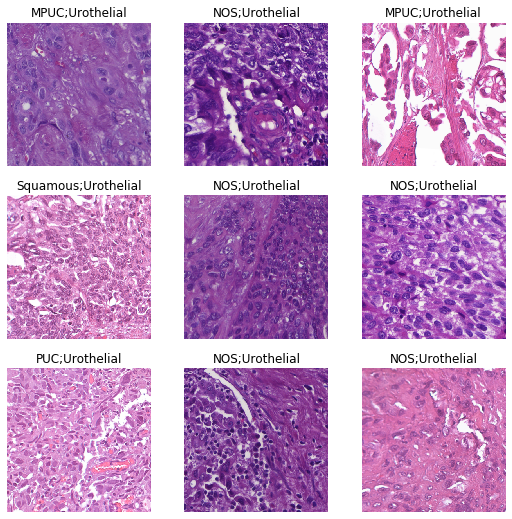

In [37]:
dls.show_batch()

# learner

## n

In [38]:
n=1

## create

In [39]:
arch = torchvision.models.resnet50

In [40]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [41]:
learner.to_fp16()
learner.path
learner.path.parent.mkdir(exist_ok=True)
learner.path.mkdir(exist_ok=True)

## name

In [42]:
epochs_frozen = 5
epochs_unfrozen = 10

In [43]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'1-resnet50'

## train

In [ ]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

In [ ]:
learner.recorder.plot_lr_find()

In [ ]:
lr1 = 6e-1

In [47]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

In [48]:
pd.read_csv(learner.path/log_head_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,NaN,NaN,0.856509,4:47:27
1,1,NaN,NaN,0.856509,3:55:43
2,2,NaN,NaN,0.856509,3:53:42
3,3,NaN,NaN,0.856509,3:58:13
4,4,NaN,NaN,0.856509,3:51:30


In [ ]:
nameHead = f'{nameBase}-head';nameHead

In [ ]:
learner.save(nameHead)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=1e-11, end_lr=1e-2, num_it=500)

In [ ]:
lr2 = 1e-4
lr3 = 5e-3
lr4 = 1e-3

In [49]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

In [50]:
pd.read_csv(learner.path/log_complete_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,0.203939,NaN,0.856509,3:45:06
1,1,0.206666,NaN,0.856509,3:43:42
2,2,0.204709,NaN,0.856509,3:43:30
3,3,0.202614,NaN,0.856509,3:46:29
4,4,0.206851,NaN,0.856509,3:46:56
5,5,0.205751,NaN,0.856509,3:45:15
6,6,0.206229,NaN,0.856509,3:46:34
7,7,0.202713,NaN,0.856509,3:46:02
8,8,0.203815,NaN,0.856509,3:47:28
9,9,0.206351,NaN,0.856509,3:46:53


In [44]:
nameComplete = f'{nameBase}-complete'; nameComplete

'1-resnet50-complete'

In [45]:
#learner.save(nameComplete)
learner.load(nameComplete)

# prediction

In [82]:
from postprocessing.predictor import Predictor

In [83]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [ ]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, 
                          batch_size=bs)

  0%|          | 0/21082 [00:00<?, ?it/s]

  0%|          | 1/21082 [00:00<2:03:59,  2.83it/s]

  0%|          | 2/21082 [00:00<2:01:11,  2.90it/s]

  0%|          | 3/21082 [00:00<1:58:26,  2.97it/s]

  0%|          | 4/21082 [00:01<1:57:40,  2.99it/s]

  0%|          | 5/21082 [00:01<1:57:53,  2.98it/s]

  0%|          | 6/21082 [00:01<1:57:34,  2.99it/s]

  0%|          | 7/21082 [00:02<1:55:38,  3.04it/s]

  0%|          | 8/21082 [00:02<1:53:11,  3.10it/s]

  0%|          | 9/21082 [00:03<2:08:47,  2.73it/s]

  0%|          | 10/21082 [00:03<2:02:46,  2.86it/s]

  0%|          | 11/21082 [00:03<1:59:49,  2.93it/s]

  0%|          | 12/21082 [00:04<2:15:49,  2.59it/s]

  0%|          | 13/21082 [00:04<2:06:36,  2.77it/s]

  0%|          | 14/21082 [00:04<2:01:29,  2.89it/s]

  0%|          | 15/21082 [00:05<2:14:32,  2.61it/s]

  0%|          | 16/21082 [00:05<2:09:17,  2.72it/s]

  0%|          | 17/21082 [00:06<2:13:00,  2.64it/s]

  0%|          | 18/21082 [00:06<2:18:02,  2.54it/s]

  0%|          | 19/21082 [00:06<2:24:28,  2.43it/s]

  0%|          | 20/21082 [00:07<2:13:28,  2.63it/s]

  0%|          | 21/21082 [00:07<2:25:20,  2.42it/s]

  0%|          | 22/21082 [00:08<2:21:43,  2.48it/s]

  0%|          | 23/21082 [00:08<2:13:43,  2.62it/s]

  0%|          | 24/21082 [00:08<2:19:32,  2.52it/s]

  0%|          | 25/21082 [00:09<2:35:26,  2.26it/s]

  0%|          | 26/21082 [00:09<2:24:14,  2.43it/s]

  0%|          | 27/21082 [00:10<2:19:07,  2.52it/s]

  0%|          | 28/21082 [00:10<2:37:00,  2.23it/s]

  0%|          | 29/21082 [00:11<2:33:23,  2.29it/s]

  0%|          | 30/21082 [00:11<2:18:31,  2.53it/s]

  0%|          | 31/21082 [00:11<2:17:23,  2.55it/s]

  0%|          | 32/21082 [00:12<2:31:17,  2.32it/s]

  0%|          | 33/21082 [00:12<2:35:54,  2.25it/s]

  0%|          | 34/21082 [00:13<2:23:51,  2.44it/s]

  0%|          | 35/21082 [00:13<2:34:59,  2.26it/s]

  0%|          | 36/21082 [00:14<2:34:45,  2.27it/s]

  0%|          | 37/21082 [00:14<2:38:53,  2.21it/s]

  0%|          | 38/21082 [00:14<2:27:11,  2.38it/s]

  0%|          | 39/21082 [00:15<2:16:29,  2.57it/s]

  0%|          | 40/21082 [00:15<2:07:09,  2.76it/s]

  0%|          | 41/21082 [00:16<2:23:21,  2.45it/s]

  0%|          | 42/21082 [00:16<3:11:17,  1.83it/s]

  0%|          | 43/21082 [00:17<3:25:25,  1.71it/s]

  0%|          | 44/21082 [00:17<3:03:11,  1.91it/s]

  0%|          | 45/21082 [00:18<3:00:04,  1.95it/s]

  0%|          | 46/21082 [00:18<2:53:33,  2.02it/s]

  0%|          | 47/21082 [00:19<2:36:23,  2.24it/s]

  0%|          | 48/21082 [00:19<2:20:54,  2.49it/s]

  0%|          | 49/21082 [00:19<2:11:12,  2.67it/s]

  0%|          | 50/21082 [00:20<2:02:36,  2.86it/s]

  0%|          | 51/21082 [00:20<2:03:53,  2.83it/s]

  0%|          | 52/21082 [00:20<2:08:04,  2.74it/s]

  0%|          | 53/21082 [00:21<2:12:45,  2.64it/s]

  0%|          | 54/21082 [00:21<2:03:50,  2.83it/s]

  0%|          | 55/21082 [00:21<2:08:34,  2.73it/s]

  0%|          | 56/21082 [00:22<1:59:37,  2.93it/s]

  0%|          | 57/21082 [00:22<2:04:02,  2.83it/s]

  0%|          | 58/21082 [00:22<1:59:48,  2.92it/s]

  0%|          | 59/21082 [00:23<1:56:09,  3.02it/s]

  0%|          | 60/21082 [00:23<1:51:51,  3.13it/s]

  0%|          | 61/21082 [00:23<1:47:10,  3.27it/s]

  0%|          | 62/21082 [00:24<1:46:21,  3.29it/s]

  0%|          | 63/21082 [00:24<1:44:46,  3.34it/s]

  0%|          | 64/21082 [00:24<1:46:02,  3.30it/s]

  0%|          | 65/21082 [00:25<2:01:05,  2.89it/s]

  0%|          | 66/21082 [00:25<1:54:15,  3.07it/s]

  0%|          | 67/21082 [00:25<1:49:44,  3.19it/s]

  0%|          | 68/21082 [00:26<1:52:15,  3.12it/s]

  0%|          | 69/21082 [00:26<1:48:24,  3.23it/s]

  0%|          | 70/21082 [00:26<1:56:06,  3.02it/s]

  0%|          | 71/21082 [00:27<1:51:39,  3.14it/s]

  0%|          | 72/21082 [00:27<2:03:51,  2.83it/s]

  0%|          | 73/21082 [00:27<1:55:45,  3.03it/s]

  0%|          | 74/21082 [00:28<1:56:26,  3.01it/s]

  0%|          | 75/21082 [00:28<1:52:08,  3.12it/s]

  0%|          | 76/21082 [00:28<1:48:19,  3.23it/s]

  0%|          | 77/21082 [00:28<1:53:07,  3.09it/s]

  0%|          | 78/21082 [00:29<1:49:16,  3.20it/s]

  0%|          | 79/21082 [00:29<1:58:25,  2.96it/s]

  0%|          | 80/21082 [00:30<2:15:16,  2.59it/s]

  0%|          | 81/21082 [00:30<2:23:24,  2.44it/s]

  0%|          | 82/21082 [00:31<2:30:46,  2.32it/s]

  0%|          | 83/21082 [00:31<2:24:06,  2.43it/s]

  0%|          | 84/21082 [00:31<2:25:09,  2.41it/s]

  0%|          | 85/21082 [00:32<2:20:03,  2.50it/s]

  0%|          | 86/21082 [00:32<2:10:22,  2.68it/s]

  0%|          | 87/21082 [00:32<2:08:32,  2.72it/s]

  0%|          | 88/21082 [00:33<2:19:37,  2.51it/s]

  0%|          | 89/21082 [00:33<2:09:09,  2.71it/s]

  0%|          | 90/21082 [00:34<2:02:04,  2.87it/s]

  0%|          | 91/21082 [00:34<2:07:11,  2.75it/s]

  0%|          | 92/21082 [00:34<2:05:03,  2.80it/s]

  0%|          | 93/21082 [00:35<2:09:07,  2.71it/s]

  0%|          | 94/21082 [00:35<2:03:34,  2.83it/s]

  0%|          | 95/21082 [00:35<1:59:42,  2.92it/s]

  0%|          | 96/21082 [00:36<1:56:50,  2.99it/s]

  0%|          | 97/21082 [00:36<1:56:37,  3.00it/s]

  0%|          | 98/21082 [00:36<1:57:01,  2.99it/s]

  0%|          | 99/21082 [00:37<2:05:08,  2.79it/s]

  0%|          | 100/21082 [00:37<2:05:19,  2.79it/s]

  0%|          | 101/21082 [00:38<2:25:23,  2.41it/s]

  0%|          | 102/21082 [00:38<2:26:33,  2.39it/s]

  0%|          | 103/21082 [00:38<2:26:44,  2.38it/s]

  0%|          | 104/21082 [00:39<2:14:52,  2.59it/s]

  0%|          | 105/21082 [00:39<2:10:56,  2.67it/s]

  1%|          | 106/21082 [00:40<2:40:34,  2.18it/s]

  1%|          | 107/21082 [00:40<2:25:43,  2.40it/s]

  1%|          | 108/21082 [00:40<2:25:37,  2.40it/s]

  1%|          | 109/21082 [00:41<2:16:13,  2.57it/s]

  1%|          | 110/21082 [00:41<2:07:37,  2.74it/s]

  1%|          | 111/21082 [00:41<2:00:48,  2.89it/s]

  1%|          | 112/21082 [00:42<1:55:22,  3.03it/s]

  1%|          | 113/21082 [00:42<1:55:29,  3.03it/s]

  1%|          | 114/21082 [00:42<1:52:28,  3.11it/s]

  1%|          | 115/21082 [00:43<2:14:40,  2.59it/s]

  1%|          | 116/21082 [00:43<2:13:56,  2.61it/s]

  1%|          | 117/21082 [00:44<2:15:40,  2.58it/s]

  1%|          | 118/21082 [00:44<2:23:54,  2.43it/s]

  1%|          | 119/21082 [00:45<2:22:41,  2.45it/s]

  1%|          | 120/21082 [00:45<2:17:34,  2.54it/s]

  1%|          | 121/21082 [00:45<2:32:50,  2.29it/s]

  1%|          | 122/21082 [00:46<2:21:08,  2.48it/s]

  1%|          | 123/21082 [00:46<2:32:14,  2.29it/s]

  1%|          | 124/21082 [00:47<2:22:45,  2.45it/s]

  1%|          | 125/21082 [00:47<2:12:00,  2.65it/s]

  1%|          | 126/21082 [00:47<2:11:54,  2.65it/s]

  1%|          | 127/21082 [00:48<2:07:23,  2.74it/s]

  1%|          | 128/21082 [00:48<2:08:08,  2.73it/s]

  1%|          | 129/21082 [00:48<2:01:44,  2.87it/s]

  1%|          | 130/21082 [00:49<2:17:38,  2.54it/s]

  1%|          | 131/21082 [00:49<2:14:20,  2.60it/s]

  1%|          | 132/21082 [00:50<2:11:42,  2.65it/s]

  1%|          | 133/21082 [00:50<2:06:32,  2.76it/s]

  1%|          | 134/21082 [00:50<2:05:41,  2.78it/s]

  1%|          | 135/21082 [00:51<2:17:33,  2.54it/s]

  1%|          | 136/21082 [00:51<2:08:27,  2.72it/s]

  1%|          | 137/21082 [00:52<2:26:16,  2.39it/s]

  1%|          | 138/21082 [00:52<2:14:41,  2.59it/s]

  1%|          | 139/21082 [00:52<2:06:29,  2.76it/s]

  1%|          | 140/21082 [00:53<2:05:56,  2.77it/s]

  1%|          | 141/21082 [00:53<2:06:21,  2.76it/s]

  1%|          | 142/21082 [00:53<2:00:16,  2.90it/s]

  1%|          | 143/21082 [00:53<1:57:06,  2.98it/s]

  1%|          | 144/21082 [00:54<2:07:08,  2.74it/s]

  1%|          | 145/21082 [00:54<2:04:44,  2.80it/s]

  1%|          | 146/21082 [00:55<2:13:21,  2.62it/s]

  1%|          | 147/21082 [00:55<2:19:10,  2.51it/s]

  1%|          | 148/21082 [00:55<2:10:02,  2.68it/s]

  1%|          | 149/21082 [00:56<2:24:40,  2.41it/s]

  1%|          | 150/21082 [00:56<2:16:51,  2.55it/s]

  1%|          | 151/21082 [00:57<2:07:59,  2.73it/s]

  1%|          | 152/21082 [00:57<2:51:41,  2.03it/s]

  1%|          | 153/21082 [00:58<2:32:56,  2.28it/s]

  1%|          | 154/21082 [00:58<2:19:36,  2.50it/s]

  1%|          | 155/21082 [00:58<2:08:28,  2.71it/s]

  1%|          | 156/21082 [00:59<2:10:37,  2.67it/s]

  1%|          | 157/21082 [00:59<2:05:40,  2.77it/s]

  1%|          | 158/21082 [00:59<2:01:44,  2.86it/s]

  1%|          | 159/21082 [01:00<2:00:46,  2.89it/s]

  1%|          | 160/21082 [01:00<1:58:32,  2.94it/s]

  1%|          | 161/21082 [01:00<1:56:12,  3.00it/s]

  1%|          | 162/21082 [01:01<1:55:51,  3.01it/s]

  1%|          | 163/21082 [01:01<1:54:35,  3.04it/s]

  1%|          | 164/21082 [01:01<1:53:53,  3.06it/s]

  1%|          | 165/21082 [01:02<1:56:01,  3.00it/s]

  1%|          | 166/21082 [01:02<1:55:37,  3.02it/s]

  1%|          | 167/21082 [01:02<2:03:06,  2.83it/s]

  1%|          | 168/21082 [01:03<2:00:18,  2.90it/s]

  1%|          | 169/21082 [01:03<2:09:53,  2.68it/s]

  1%|          | 170/21082 [01:03<2:02:39,  2.84it/s]

  1%|          | 171/21082 [01:04<1:56:17,  3.00it/s]

  1%|          | 172/21082 [01:04<1:55:47,  3.01it/s]

  1%|          | 173/21082 [01:05<2:14:26,  2.59it/s]

  1%|          | 174/21082 [01:05<2:22:35,  2.44it/s]

  1%|          | 175/21082 [01:05<2:21:45,  2.46it/s]

  1%|          | 176/21082 [01:06<2:19:29,  2.50it/s]

  1%|          | 177/21082 [01:06<2:23:50,  2.42it/s]

  1%|          | 178/21082 [01:07<2:12:38,  2.63it/s]

  1%|          | 179/21082 [01:07<2:35:37,  2.24it/s]

  1%|          | 180/21082 [01:08<2:26:04,  2.38it/s]

  1%|          | 181/21082 [01:08<2:26:27,  2.38it/s]

  1%|          | 182/21082 [01:08<2:13:47,  2.60it/s]

  1%|          | 183/21082 [01:09<2:19:03,  2.50it/s]

  1%|          | 184/21082 [01:09<2:13:20,  2.61it/s]

  1%|          | 185/21082 [01:09<2:10:13,  2.67it/s]

  1%|          | 186/21082 [01:10<2:25:17,  2.40it/s]

  1%|          | 187/21082 [01:10<2:14:17,  2.59it/s]

  1%|          | 188/21082 [01:11<2:39:50,  2.18it/s]

  1%|          | 189/21082 [01:11<2:59:38,  1.94it/s]

  1%|          | 190/21082 [01:12<3:05:42,  1.87it/s]

  1%|          | 191/21082 [01:12<2:47:41,  2.08it/s]

  1%|          | 192/21082 [01:13<2:30:44,  2.31it/s]

  1%|          | 193/21082 [01:13<2:17:19,  2.54it/s]

  1%|          | 194/21082 [01:13<2:22:03,  2.45it/s]

  1%|          | 195/21082 [01:14<2:33:30,  2.27it/s]

  1%|          | 196/21082 [01:14<2:31:50,  2.29it/s]

  1%|          | 197/21082 [01:15<2:31:56,  2.29it/s]

  1%|          | 198/21082 [01:15<2:29:00,  2.34it/s]

  1%|          | 199/21082 [01:16<2:43:42,  2.13it/s]

  1%|          | 200/21082 [01:16<2:37:58,  2.20it/s]

  1%|          | 201/21082 [01:17<2:50:51,  2.04it/s]

  1%|          | 202/21082 [01:17<2:50:47,  2.04it/s]

  1%|          | 203/21082 [01:18<2:35:23,  2.24it/s]

  1%|          | 204/21082 [01:18<2:20:58,  2.47it/s]

  1%|          | 205/21082 [01:18<2:24:26,  2.41it/s]

  1%|          | 206/21082 [01:19<2:37:03,  2.22it/s]

  1%|          | 207/21082 [01:19<2:40:46,  2.16it/s]

  1%|          | 208/21082 [01:20<2:30:00,  2.32it/s]

  1%|          | 209/21082 [01:20<2:21:01,  2.47it/s]

  1%|          | 210/21082 [01:20<2:11:54,  2.64it/s]

  1%|          | 211/21082 [01:21<2:14:56,  2.58it/s]

  1%|          | 212/21082 [01:21<2:05:29,  2.77it/s]

  1%|          | 213/21082 [01:21<2:00:23,  2.89it/s]

  1%|          | 214/21082 [01:22<2:00:26,  2.89it/s]

  1%|          | 215/21082 [01:22<2:00:35,  2.88it/s]

  1%|          | 216/21082 [01:24<3:42:52,  1.56it/s]

  1%|          | 217/21082 [01:24<3:08:19,  1.85it/s]

  1%|          | 218/21082 [01:24<2:43:01,  2.13it/s]

  1%|          | 219/21082 [01:24<2:25:06,  2.40it/s]

  1%|          | 220/21082 [01:25<2:26:10,  2.38it/s]

  1%|          | 221/21082 [01:25<2:19:07,  2.50it/s]

  1%|          | 222/21082 [01:26<2:09:24,  2.69it/s]

  1%|          | 223/21082 [01:26<2:07:21,  2.73it/s]

  1%|          | 224/21082 [01:26<2:18:12,  2.52it/s]

  1%|          | 225/21082 [01:27<2:23:46,  2.42it/s]

  1%|          | 226/21082 [01:27<2:36:41,  2.22it/s]

  1%|          | 227/21082 [01:28<2:42:37,  2.14it/s]

  1%|          | 228/21082 [01:28<2:39:30,  2.18it/s]

  1%|          | 229/21082 [01:29<2:25:06,  2.39it/s]

  1%|          | 230/21082 [01:29<2:15:14,  2.57it/s]

  1%|          | 231/21082 [01:29<2:16:25,  2.55it/s]

  1%|          | 232/21082 [01:30<2:21:47,  2.45it/s]

  1%|          | 233/21082 [01:30<2:32:00,  2.29it/s]

  1%|          | 234/21082 [01:31<2:26:36,  2.37it/s]

  1%|          | 235/21082 [01:31<2:30:12,  2.31it/s]

  1%|          | 236/21082 [01:31<2:22:21,  2.44it/s]

  1%|          | 237/21082 [01:32<2:16:42,  2.54it/s]

  1%|          | 238/21082 [01:32<2:07:34,  2.72it/s]

  1%|          | 239/21082 [01:33<2:18:59,  2.50it/s]

  1%|          | 240/21082 [01:33<2:15:45,  2.56it/s]

  1%|          | 241/21082 [01:33<2:19:47,  2.48it/s]

  1%|          | 242/21082 [01:34<2:32:57,  2.27it/s]

  1%|          | 243/21082 [01:34<2:25:33,  2.39it/s]

  1%|          | 244/21082 [01:35<2:52:33,  2.01it/s]

  1%|          | 245/21082 [01:35<2:43:28,  2.12it/s]

  1%|          | 246/21082 [01:36<2:29:02,  2.33it/s]

  1%|          | 247/21082 [01:36<2:35:29,  2.23it/s]

  1%|          | 248/21082 [01:37<2:25:07,  2.39it/s]

  1%|          | 249/21082 [01:37<2:13:55,  2.59it/s]

  1%|          | 250/21082 [01:37<2:14:09,  2.59it/s]

  1%|          | 251/21082 [01:38<2:09:01,  2.69it/s]

  1%|          | 252/21082 [01:38<2:02:23,  2.84it/s]

  1%|          | 253/21082 [01:38<2:13:56,  2.59it/s]

  1%|          | 254/21082 [01:39<2:05:32,  2.76it/s]

  1%|          | 255/21082 [01:39<2:02:36,  2.83it/s]

  1%|          | 256/21082 [01:39<1:58:56,  2.92it/s]

  1%|          | 257/21082 [01:40<2:00:56,  2.87it/s]

  1%|          | 258/21082 [01:40<2:00:47,  2.87it/s]

  1%|          | 259/21082 [01:40<2:02:18,  2.84it/s]

  1%|          | 260/21082 [01:41<2:24:02,  2.41it/s]

  1%|          | 261/21082 [01:41<2:33:01,  2.27it/s]

  1%|          | 262/21082 [01:42<2:27:30,  2.35it/s]

  1%|          | 263/21082 [01:42<2:30:31,  2.31it/s]

  1%|▏         | 264/21082 [01:43<2:28:05,  2.34it/s]

  1%|▏         | 265/21082 [01:43<2:15:12,  2.57it/s]

  1%|▏         | 266/21082 [01:44<2:26:39,  2.37it/s]

  1%|▏         | 267/21082 [01:44<2:28:13,  2.34it/s]

  1%|▏         | 268/21082 [01:45<2:46:39,  2.08it/s]

  1%|▏         | 269/21082 [01:45<2:43:52,  2.12it/s]

  1%|▏         | 270/21082 [01:45<2:32:45,  2.27it/s]

  1%|▏         | 271/21082 [01:46<2:43:48,  2.12it/s]

  1%|▏         | 272/21082 [01:46<2:41:54,  2.14it/s]

  1%|▏         | 273/21082 [01:47<2:47:52,  2.07it/s]

  1%|▏         | 274/21082 [01:48<3:32:20,  1.63it/s]

  1%|▏         | 275/21082 [01:48<3:00:59,  1.92it/s]

  1%|▏         | 276/21082 [01:48<2:44:53,  2.10it/s]

  1%|▏         | 277/21082 [01:49<2:32:28,  2.27it/s]

  1%|▏         | 278/21082 [01:49<2:19:04,  2.49it/s]

  1%|▏         | 279/21082 [01:49<2:12:24,  2.62it/s]

  1%|▏         | 280/21082 [01:50<2:10:50,  2.65it/s]

  1%|▏         | 281/21082 [01:50<2:15:05,  2.57it/s]

  1%|▏         | 282/21082 [01:51<2:08:00,  2.71it/s]

  1%|▏         | 283/21082 [01:51<2:00:43,  2.87it/s]

  1%|▏         | 284/21082 [01:51<1:58:19,  2.93it/s]

  1%|▏         | 285/21082 [01:52<2:34:12,  2.25it/s]

  1%|▏         | 286/21082 [01:52<2:22:51,  2.43it/s]

  1%|▏         | 287/21082 [01:53<2:13:11,  2.60it/s]

  1%|▏         | 288/21082 [01:53<2:08:59,  2.69it/s]

  1%|▏         | 289/21082 [01:53<2:29:10,  2.32it/s]

  1%|▏         | 290/21082 [01:54<2:20:31,  2.47it/s]

  1%|▏         | 291/21082 [01:54<2:11:45,  2.63it/s]

  1%|▏         | 292/21082 [01:54<2:04:16,  2.79it/s]

  1%|▏         | 293/21082 [01:55<1:59:34,  2.90it/s]

  1%|▏         | 294/21082 [01:55<1:55:22,  3.00it/s]

  1%|▏         | 295/21082 [01:55<1:52:59,  3.07it/s]

  1%|▏         | 296/21082 [01:56<1:56:12,  2.98it/s]

  1%|▏         | 297/21082 [01:56<1:55:10,  3.01it/s]

  1%|▏         | 298/21082 [01:56<1:54:21,  3.03it/s]

  1%|▏         | 299/21082 [01:57<2:09:41,  2.67it/s]

  1%|▏         | 300/21082 [01:57<2:04:48,  2.78it/s]

  1%|▏         | 301/21082 [01:57<1:59:35,  2.90it/s]

  1%|▏         | 302/21082 [01:58<1:55:03,  3.01it/s]

  1%|▏         | 303/21082 [01:58<1:52:17,  3.08it/s]

  1%|▏         | 304/21082 [01:58<1:56:10,  2.98it/s]

  1%|▏         | 305/21082 [01:59<1:54:46,  3.02it/s]

  1%|▏         | 306/21082 [01:59<1:51:52,  3.10it/s]

  1%|▏         | 307/21082 [01:59<1:49:45,  3.15it/s]

  1%|▏         | 308/21082 [02:00<1:48:30,  3.19it/s]

  1%|▏         | 309/21082 [02:00<1:47:46,  3.21it/s]

  1%|▏         | 310/21082 [02:00<1:56:37,  2.97it/s]

  1%|▏         | 311/21082 [02:01<1:53:09,  3.06it/s]

  1%|▏         | 312/21082 [02:01<2:18:58,  2.49it/s]

  1%|▏         | 313/21082 [02:02<2:25:19,  2.38it/s]

  1%|▏         | 314/21082 [02:02<2:13:24,  2.59it/s]

  1%|▏         | 315/21082 [02:02<2:06:21,  2.74it/s]

  1%|▏         | 316/21082 [02:03<2:01:18,  2.85it/s]

  2%|▏         | 317/21082 [02:03<1:57:32,  2.94it/s]

  2%|▏         | 318/21082 [02:03<1:54:22,  3.03it/s]

  2%|▏         | 319/21082 [02:04<1:51:59,  3.09it/s]

  2%|▏         | 320/21082 [02:04<1:51:34,  3.10it/s]

  2%|▏         | 321/21082 [02:04<1:49:54,  3.15it/s]

  2%|▏         | 322/21082 [02:05<1:49:59,  3.15it/s]

  2%|▏         | 323/21082 [02:05<1:50:37,  3.13it/s]

  2%|▏         | 324/21082 [02:05<1:52:25,  3.08it/s]

  2%|▏         | 325/21082 [02:06<1:54:46,  3.01it/s]

  2%|▏         | 326/21082 [02:06<1:53:36,  3.05it/s]

  2%|▏         | 327/21082 [02:06<1:52:02,  3.09it/s]

  2%|▏         | 328/21082 [02:07<2:03:57,  2.79it/s]

  2%|▏         | 329/21082 [02:07<1:59:13,  2.90it/s]

  2%|▏         | 330/21082 [02:07<1:55:01,  3.01it/s]

  2%|▏         | 331/21082 [02:08<1:54:06,  3.03it/s]

  2%|▏         | 332/21082 [02:08<1:52:08,  3.08it/s]

  2%|▏         | 333/21082 [02:08<1:55:13,  3.00it/s]

  2%|▏         | 334/21082 [02:09<2:00:53,  2.86it/s]

  2%|▏         | 335/21082 [02:09<2:09:07,  2.68it/s]

  2%|▏         | 336/21082 [02:09<2:01:59,  2.83it/s]

  2%|▏         | 337/21082 [02:10<2:04:28,  2.78it/s]

  2%|▏         | 338/21082 [02:10<2:00:11,  2.88it/s]

  2%|▏         | 339/21082 [02:11<2:22:18,  2.43it/s]

  2%|▏         | 340/21082 [02:11<2:10:30,  2.65it/s]

  2%|▏         | 341/21082 [02:11<2:05:42,  2.75it/s]

  2%|▏         | 342/21082 [02:12<2:00:55,  2.86it/s]

  2%|▏         | 343/21082 [02:12<1:58:15,  2.92it/s]

  2%|▏         | 344/21082 [02:12<1:56:02,  2.98it/s]

  2%|▏         | 345/21082 [02:13<1:53:23,  3.05it/s]

  2%|▏         | 346/21082 [02:13<1:53:01,  3.06it/s]

  2%|▏         | 347/21082 [02:13<1:54:19,  3.02it/s]

  2%|▏         | 348/21082 [02:14<1:52:43,  3.07it/s]

  2%|▏         | 349/21082 [02:14<1:50:10,  3.14it/s]

  2%|▏         | 350/21082 [02:14<1:52:09,  3.08it/s]

  2%|▏         | 351/21082 [02:15<2:11:36,  2.63it/s]

  2%|▏         | 352/21082 [02:15<2:03:26,  2.80it/s]

  2%|▏         | 353/21082 [02:15<2:17:13,  2.52it/s]

  2%|▏         | 354/21082 [02:16<2:08:47,  2.68it/s]

  2%|▏         | 355/21082 [02:16<2:03:06,  2.81it/s]

  2%|▏         | 356/21082 [02:16<1:57:42,  2.93it/s]

  2%|▏         | 357/21082 [02:17<1:54:08,  3.03it/s]

  2%|▏         | 358/21082 [02:17<1:51:43,  3.09it/s]

  2%|▏         | 359/21082 [02:17<1:54:04,  3.03it/s]

  2%|▏         | 360/21082 [02:18<1:51:34,  3.10it/s]

  2%|▏         | 361/21082 [02:18<1:49:28,  3.15it/s]

  2%|▏         | 362/21082 [02:18<2:07:53,  2.70it/s]

  2%|▏         | 363/21082 [02:19<2:24:17,  2.39it/s]

  2%|▏         | 364/21082 [02:19<2:32:35,  2.26it/s]

  2%|▏         | 365/21082 [02:20<2:21:44,  2.44it/s]

  2%|▏         | 366/21082 [02:20<2:44:10,  2.10it/s]

  2%|▏         | 367/21082 [02:21<2:45:11,  2.09it/s]

  2%|▏         | 368/21082 [02:21<2:26:31,  2.36it/s]

  2%|▏         | 369/21082 [02:22<2:23:30,  2.41it/s]

  2%|▏         | 370/21082 [02:22<2:18:06,  2.50it/s]

  2%|▏         | 371/21082 [02:22<2:28:01,  2.33it/s]

  2%|▏         | 372/21082 [02:23<2:15:38,  2.54it/s]

  2%|▏         | 373/21082 [02:23<2:08:55,  2.68it/s]

  2%|▏         | 374/21082 [02:23<2:02:34,  2.82it/s]

  2%|▏         | 375/21082 [02:24<2:18:04,  2.50it/s]

  2%|▏         | 376/21082 [02:24<2:16:09,  2.53it/s]

  2%|▏         | 377/21082 [02:25<2:07:14,  2.71it/s]

  2%|▏         | 378/21082 [02:25<2:14:14,  2.57it/s]

  2%|▏         | 379/21082 [02:26<2:24:52,  2.38it/s]

  2%|▏         | 380/21082 [02:26<2:15:02,  2.56it/s]

  2%|▏         | 381/21082 [02:26<2:16:27,  2.53it/s]

  2%|▏         | 382/21082 [02:27<2:07:49,  2.70it/s]

  2%|▏         | 383/21082 [02:27<2:05:22,  2.75it/s]

  2%|▏         | 384/21082 [02:27<2:17:36,  2.51it/s]

  2%|▏         | 385/21082 [02:28<2:07:43,  2.70it/s]

  2%|▏         | 386/21082 [02:28<2:02:17,  2.82it/s]

  2%|▏         | 387/21082 [02:29<2:47:27,  2.06it/s]

  2%|▏         | 388/21082 [02:29<2:38:15,  2.18it/s]

  2%|▏         | 389/21082 [02:30<2:29:05,  2.31it/s]

  2%|▏         | 390/21082 [02:30<2:20:51,  2.45it/s]

  2%|▏         | 391/21082 [02:30<2:17:04,  2.52it/s]

  2%|▏         | 392/21082 [02:31<2:07:05,  2.71it/s]

  2%|▏         | 393/21082 [02:31<2:03:20,  2.80it/s]

  2%|▏         | 394/21082 [02:31<1:57:18,  2.94it/s]

  2%|▏         | 395/21082 [02:32<1:59:26,  2.89it/s]

  2%|▏         | 396/21082 [02:32<1:54:36,  3.01it/s]

  2%|▏         | 397/21082 [02:32<2:11:32,  2.62it/s]

  2%|▏         | 398/21082 [02:33<2:26:00,  2.36it/s]

  2%|▏         | 399/21082 [02:33<2:35:23,  2.22it/s]

  2%|▏         | 400/21082 [02:34<2:43:47,  2.10it/s]

  2%|▏         | 401/21082 [02:34<2:38:26,  2.18it/s]

  2%|▏         | 402/21082 [02:35<2:24:02,  2.39it/s]

  2%|▏         | 403/21082 [02:35<2:18:02,  2.50it/s]

  2%|▏         | 404/21082 [02:35<2:18:26,  2.49it/s]

  2%|▏         | 405/21082 [02:36<2:18:52,  2.48it/s]

  2%|▏         | 406/21082 [02:36<2:34:28,  2.23it/s]

  2%|▏         | 407/21082 [02:37<2:31:16,  2.28it/s]

  2%|▏         | 408/21082 [02:37<2:29:41,  2.30it/s]

  2%|▏         | 409/21082 [02:38<2:25:03,  2.38it/s]

  2%|▏         | 410/21082 [02:38<2:36:17,  2.20it/s]

  2%|▏         | 411/21082 [02:39<2:20:27,  2.45it/s]

  2%|▏         | 412/21082 [02:39<2:09:39,  2.66it/s]

  2%|▏         | 413/21082 [02:39<2:02:35,  2.81it/s]

  2%|▏         | 414/21082 [02:39<2:02:05,  2.82it/s]

  2%|▏         | 415/21082 [02:40<2:07:44,  2.70it/s]

  2%|▏         | 416/21082 [02:40<2:00:18,  2.86it/s]

  2%|▏         | 417/21082 [02:40<1:55:10,  2.99it/s]

  2%|▏         | 418/21082 [02:41<2:09:46,  2.65it/s]

  2%|▏         | 419/21082 [02:41<2:07:31,  2.70it/s]

  2%|▏         | 420/21082 [02:42<2:01:32,  2.83it/s]

  2%|▏         | 421/21082 [02:42<1:58:03,  2.92it/s]

  2%|▏         | 422/21082 [02:42<1:54:10,  3.02it/s]

  2%|▏         | 423/21082 [02:43<1:54:49,  3.00it/s]

  2%|▏         | 424/21082 [02:43<2:08:06,  2.69it/s]

  2%|▏         | 425/21082 [02:44<2:23:17,  2.40it/s]

  2%|▏         | 426/21082 [02:44<2:14:48,  2.55it/s]

  2%|▏         | 427/21082 [02:44<2:10:45,  2.63it/s]

  2%|▏         | 428/21082 [02:45<2:07:06,  2.71it/s]

  2%|▏         | 429/21082 [02:45<2:04:59,  2.75it/s]

  2%|▏         | 430/21082 [02:45<2:06:25,  2.72it/s]

  2%|▏         | 431/21082 [02:46<2:25:49,  2.36it/s]

  2%|▏         | 432/21082 [02:46<2:14:08,  2.57it/s]

  2%|▏         | 433/21082 [02:47<2:06:38,  2.72it/s]

  2%|▏         | 434/21082 [02:47<2:24:13,  2.39it/s]

  2%|▏         | 435/21082 [02:48<2:33:07,  2.25it/s]

  2%|▏         | 436/21082 [02:48<2:18:40,  2.48it/s]

  2%|▏         | 437/21082 [02:48<2:06:55,  2.71it/s]

  2%|▏         | 438/21082 [02:48<2:00:27,  2.86it/s]

  2%|▏         | 439/21082 [02:49<2:24:53,  2.37it/s]

  2%|▏         | 440/21082 [02:49<2:13:59,  2.57it/s]

  2%|▏         | 441/21082 [02:50<2:16:55,  2.51it/s]

  2%|▏         | 442/21082 [02:50<2:06:06,  2.73it/s]

  2%|▏         | 443/21082 [02:50<2:06:51,  2.71it/s]

  2%|▏         | 444/21082 [02:51<2:00:12,  2.86it/s]

  2%|▏         | 445/21082 [02:51<1:55:28,  2.98it/s]

  2%|▏         | 446/21082 [02:51<1:52:25,  3.06it/s]

  2%|▏         | 447/21082 [02:52<1:50:00,  3.13it/s]

  2%|▏         | 448/21082 [02:52<1:58:35,  2.90it/s]

  2%|▏         | 449/21082 [02:52<1:53:44,  3.02it/s]

  2%|▏         | 450/21082 [02:53<1:56:14,  2.96it/s]

  2%|▏         | 451/21082 [02:53<2:10:18,  2.64it/s]

  2%|▏         | 452/21082 [02:54<2:10:40,  2.63it/s]

  2%|▏         | 453/21082 [02:54<2:14:08,  2.56it/s]

  2%|▏         | 454/21082 [02:54<2:15:33,  2.54it/s]

  2%|▏         | 455/21082 [02:55<2:08:58,  2.67it/s]

  2%|▏         | 456/21082 [02:55<2:09:41,  2.65it/s]

  2%|▏         | 457/21082 [02:55<2:06:31,  2.72it/s]

  2%|▏         | 458/21082 [02:56<2:13:01,  2.58it/s]

  2%|▏         | 459/21082 [02:56<2:04:39,  2.76it/s]

  2%|▏         | 460/21082 [02:57<1:58:49,  2.89it/s]

  2%|▏         | 461/21082 [02:57<2:04:26,  2.76it/s]

  2%|▏         | 462/21082 [02:57<1:59:17,  2.88it/s]

  2%|▏         | 463/21082 [02:58<1:56:34,  2.95it/s]

  2%|▏         | 464/21082 [02:58<1:52:56,  3.04it/s]

  2%|▏         | 465/21082 [02:58<1:50:29,  3.11it/s]

  2%|▏         | 466/21082 [02:59<2:07:32,  2.69it/s]

  2%|▏         | 467/21082 [02:59<2:02:36,  2.80it/s]

  2%|▏         | 468/21082 [02:59<2:10:44,  2.63it/s]

  2%|▏         | 469/21082 [03:00<2:16:36,  2.51it/s]

  2%|▏         | 470/21082 [03:00<2:10:20,  2.64it/s]

  2%|▏         | 471/21082 [03:00<2:05:24,  2.74it/s]

  2%|▏         | 472/21082 [03:01<2:01:12,  2.83it/s]

  2%|▏         | 473/21082 [03:01<2:07:41,  2.69it/s]

  2%|▏         | 474/21082 [03:02<2:01:19,  2.83it/s]

  2%|▏         | 475/21082 [03:02<1:56:20,  2.95it/s]

  2%|▏         | 476/21082 [03:02<1:53:31,  3.03it/s]

  2%|▏         | 477/21082 [03:02<1:52:58,  3.04it/s]

  2%|▏         | 478/21082 [03:03<1:50:15,  3.11it/s]

  2%|▏         | 479/21082 [03:03<1:56:52,  2.94it/s]

  2%|▏         | 480/21082 [03:04<2:01:11,  2.83it/s]

  2%|▏         | 481/21082 [03:04<2:02:19,  2.81it/s]

  2%|▏         | 482/21082 [03:04<1:56:40,  2.94it/s]

  2%|▏         | 483/21082 [03:05<1:58:19,  2.90it/s]

  2%|▏         | 484/21082 [03:05<2:04:55,  2.75it/s]

  2%|▏         | 485/21082 [03:05<2:06:36,  2.71it/s]

  2%|▏         | 486/21082 [03:06<2:00:30,  2.85it/s]

  2%|▏         | 487/21082 [03:06<2:03:34,  2.78it/s]

  2%|▏         | 488/21082 [03:07<2:17:24,  2.50it/s]

  2%|▏         | 489/21082 [03:07<2:17:27,  2.50it/s]

  2%|▏         | 490/21082 [03:07<2:07:24,  2.69it/s]

  2%|▏         | 491/21082 [03:08<3:14:09,  1.77it/s]

  2%|▏         | 492/21082 [03:09<2:46:27,  2.06it/s]

  2%|▏         | 493/21082 [03:09<2:28:14,  2.31it/s]

  2%|▏         | 494/21082 [03:09<2:18:30,  2.48it/s]

  2%|▏         | 495/21082 [03:10<2:08:40,  2.67it/s]

  2%|▏         | 496/21082 [03:10<2:04:58,  2.75it/s]

  2%|▏         | 497/21082 [03:10<1:57:57,  2.91it/s]

  2%|▏         | 498/21082 [03:11<2:14:43,  2.55it/s]

  2%|▏         | 499/21082 [03:11<2:06:44,  2.71it/s]

  2%|▏         | 500/21082 [03:11<2:02:13,  2.81it/s]

  2%|▏         | 501/21082 [03:12<1:59:19,  2.87it/s]

  2%|▏         | 502/21082 [03:12<1:59:36,  2.87it/s]

  2%|▏         | 503/21082 [03:12<1:56:06,  2.95it/s]

  2%|▏         | 504/21082 [03:13<2:18:45,  2.47it/s]

  2%|▏         | 505/21082 [03:13<2:18:39,  2.47it/s]

  2%|▏         | 506/21082 [03:14<2:12:27,  2.59it/s]

  2%|▏         | 507/21082 [03:14<2:03:18,  2.78it/s]

  2%|▏         | 508/21082 [03:14<2:19:21,  2.46it/s]

  2%|▏         | 509/21082 [03:15<2:08:34,  2.67it/s]

  2%|▏         | 510/21082 [03:15<2:00:51,  2.84it/s]

  2%|▏         | 511/21082 [03:15<1:55:13,  2.98it/s]

  2%|▏         | 512/21082 [03:16<1:53:40,  3.02it/s]

  2%|▏         | 513/21082 [03:16<1:50:28,  3.10it/s]

  2%|▏         | 514/21082 [03:16<1:48:47,  3.15it/s]

  2%|▏         | 515/21082 [03:17<1:50:06,  3.11it/s]

  2%|▏         | 516/21082 [03:17<1:48:29,  3.16it/s]

  2%|▏         | 517/21082 [03:17<1:54:07,  3.00it/s]

  2%|▏         | 518/21082 [03:18<1:57:29,  2.92it/s]

  2%|▏         | 519/21082 [03:18<1:56:05,  2.95it/s]

  2%|▏         | 520/21082 [03:18<2:06:29,  2.71it/s]

  2%|▏         | 521/21082 [03:19<1:59:01,  2.88it/s]

  2%|▏         | 522/21082 [03:19<1:54:46,  2.99it/s]

  2%|▏         | 523/21082 [03:19<1:51:52,  3.06it/s]

  2%|▏         | 524/21082 [03:20<1:49:43,  3.12it/s]

  2%|▏         | 525/21082 [03:20<1:48:38,  3.15it/s]

  2%|▏         | 526/21082 [03:20<1:51:23,  3.08it/s]

  2%|▏         | 527/21082 [03:21<1:51:05,  3.08it/s]

  3%|▎         | 528/21082 [03:21<1:52:01,  3.06it/s]

  3%|▎         | 529/21082 [03:21<1:49:17,  3.13it/s]

  3%|▎         | 530/21082 [03:22<1:48:54,  3.15it/s]

  3%|▎         | 531/21082 [03:22<1:49:22,  3.13it/s]

  3%|▎         | 532/21082 [03:23<2:28:47,  2.30it/s]

  3%|▎         | 533/21082 [03:23<2:15:39,  2.52it/s]

  3%|▎         | 534/21082 [03:23<2:18:24,  2.47it/s]

  3%|▎         | 535/21082 [03:24<2:09:50,  2.64it/s]

  3%|▎         | 536/21082 [03:24<2:06:02,  2.72it/s]

  3%|▎         | 537/21082 [03:24<2:02:39,  2.79it/s]

  3%|▎         | 538/21082 [03:25<1:58:38,  2.89it/s]

  3%|▎         | 539/21082 [03:25<1:57:01,  2.93it/s]

  3%|▎         | 540/21082 [03:25<2:00:49,  2.83it/s]

  3%|▎         | 541/21082 [03:26<1:56:22,  2.94it/s]

  3%|▎         | 542/21082 [03:26<1:53:56,  3.00it/s]

  3%|▎         | 543/21082 [03:26<1:50:54,  3.09it/s]

  3%|▎         | 544/21082 [03:27<2:00:33,  2.84it/s]

  3%|▎         | 545/21082 [03:27<1:57:40,  2.91it/s]

  3%|▎         | 546/21082 [03:27<1:57:29,  2.91it/s]

  3%|▎         | 547/21082 [03:28<1:53:41,  3.01it/s]

  3%|▎         | 548/21082 [03:28<1:51:38,  3.07it/s]

  3%|▎         | 549/21082 [03:28<1:50:33,  3.10it/s]

  3%|▎         | 550/21082 [03:29<1:50:16,  3.10it/s]

  3%|▎         | 551/21082 [03:29<1:54:07,  3.00it/s]

  3%|▎         | 552/21082 [03:29<1:50:41,  3.09it/s]

  3%|▎         | 553/21082 [03:30<1:49:40,  3.12it/s]

  3%|▎         | 554/21082 [03:30<1:48:09,  3.16it/s]

  3%|▎         | 555/21082 [03:30<1:57:21,  2.92it/s]

  3%|▎         | 556/21082 [03:31<1:53:25,  3.02it/s]

  3%|▎         | 557/21082 [03:31<1:50:51,  3.09it/s]

  3%|▎         | 558/21082 [03:31<1:51:16,  3.07it/s]

  3%|▎         | 559/21082 [03:32<1:51:01,  3.08it/s]

  3%|▎         | 560/21082 [03:32<2:07:24,  2.68it/s]

  3%|▎         | 561/21082 [03:32<2:03:20,  2.77it/s]

  3%|▎         | 562/21082 [03:33<2:04:42,  2.74it/s]

  3%|▎         | 563/21082 [03:33<2:09:44,  2.64it/s]

  3%|▎         | 564/21082 [03:34<2:08:28,  2.66it/s]

  3%|▎         | 565/21082 [03:34<2:02:27,  2.79it/s]

  3%|▎         | 566/21082 [03:34<1:59:16,  2.87it/s]

  3%|▎         | 567/21082 [03:35<2:09:57,  2.63it/s]

  3%|▎         | 568/21082 [03:35<2:12:08,  2.59it/s]

  3%|▎         | 569/21082 [03:35<2:05:30,  2.72it/s]

  3%|▎         | 570/21082 [03:36<1:59:22,  2.86it/s]

  3%|▎         | 571/21082 [03:36<1:55:02,  2.97it/s]

  3%|▎         | 572/21082 [03:36<1:50:10,  3.10it/s]

  3%|▎         | 573/21082 [03:37<2:03:17,  2.77it/s]

  3%|▎         | 574/21082 [03:37<1:56:46,  2.93it/s]

  3%|▎         | 575/21082 [03:37<1:57:33,  2.91it/s]

  3%|▎         | 576/21082 [03:38<1:53:25,  3.01it/s]

  3%|▎         | 577/21082 [03:38<1:51:07,  3.08it/s]

  3%|▎         | 578/21082 [03:38<1:52:21,  3.04it/s]

  3%|▎         | 579/21082 [03:39<1:52:34,  3.04it/s]

  3%|▎         | 580/21082 [03:39<2:12:04,  2.59it/s]

  3%|▎         | 581/21082 [03:40<2:14:47,  2.54it/s]

  3%|▎         | 582/21082 [03:40<2:17:37,  2.48it/s]

  3%|▎         | 583/21082 [03:40<2:07:27,  2.68it/s]

  3%|▎         | 584/21082 [03:41<2:00:34,  2.83it/s]

  3%|▎         | 585/21082 [03:41<1:55:18,  2.96it/s]

  3%|▎         | 586/21082 [03:41<1:51:40,  3.06it/s]

  3%|▎         | 587/21082 [03:42<2:01:12,  2.82it/s]

  3%|▎         | 588/21082 [03:42<1:56:28,  2.93it/s]

  3%|▎         | 589/21082 [03:42<1:53:54,  3.00it/s]

  3%|▎         | 590/21082 [03:43<1:54:24,  2.99it/s]

  3%|▎         | 591/21082 [03:43<1:54:28,  2.98it/s]

  3%|▎         | 592/21082 [03:43<2:06:41,  2.70it/s]

  3%|▎         | 593/21082 [03:44<1:59:54,  2.85it/s]

  3%|▎         | 594/21082 [03:44<1:55:07,  2.97it/s]

  3%|▎         | 595/21082 [03:44<1:51:04,  3.07it/s]

  3%|▎         | 596/21082 [03:45<1:49:57,  3.11it/s]

  3%|▎         | 597/21082 [03:45<1:49:22,  3.12it/s]

  3%|▎         | 598/21082 [03:45<1:49:57,  3.10it/s]

  3%|▎         | 599/21082 [03:46<1:59:06,  2.87it/s]

  3%|▎         | 600/21082 [03:46<1:56:08,  2.94it/s]

  3%|▎         | 601/21082 [03:46<1:53:26,  3.01it/s]

  3%|▎         | 602/21082 [03:47<1:50:20,  3.09it/s]

  3%|▎         | 603/21082 [03:47<1:52:31,  3.03it/s]

  3%|▎         | 604/21082 [03:47<1:49:45,  3.11it/s]

  3%|▎         | 605/21082 [03:48<1:50:23,  3.09it/s]

  3%|▎         | 606/21082 [03:48<1:48:42,  3.14it/s]

  3%|▎         | 607/21082 [03:48<1:48:07,  3.16it/s]

  3%|▎         | 608/21082 [03:48<1:46:29,  3.20it/s]

  3%|▎         | 609/21082 [03:49<1:45:46,  3.23it/s]

  3%|▎         | 610/21082 [03:49<1:50:09,  3.10it/s]

  3%|▎         | 611/21082 [03:49<1:49:19,  3.12it/s]

  3%|▎         | 612/21082 [03:50<1:51:48,  3.05it/s]

  3%|▎         | 613/21082 [03:50<1:52:32,  3.03it/s]

  3%|▎         | 614/21082 [03:51<1:59:44,  2.85it/s]

  3%|▎         | 615/21082 [03:51<2:08:31,  2.65it/s]

  3%|▎         | 616/21082 [03:51<2:20:39,  2.43it/s]

  3%|▎         | 617/21082 [03:52<2:10:42,  2.61it/s]

  3%|▎         | 618/21082 [03:52<2:03:24,  2.76it/s]

  3%|▎         | 619/21082 [03:53<2:12:33,  2.57it/s]

  3%|▎         | 620/21082 [03:53<2:30:45,  2.26it/s]

  3%|▎         | 621/21082 [03:54<2:31:00,  2.26it/s]

  3%|▎         | 622/21082 [03:54<2:56:40,  1.93it/s]

  3%|▎         | 623/21082 [03:55<2:37:39,  2.16it/s]

  3%|▎         | 624/21082 [03:55<2:21:49,  2.40it/s]

  3%|▎         | 625/21082 [03:55<2:10:45,  2.61it/s]

  3%|▎         | 626/21082 [03:56<2:19:38,  2.44it/s]

  3%|▎         | 627/21082 [03:56<2:09:10,  2.64it/s]

  3%|▎         | 628/21082 [03:56<2:08:38,  2.65it/s]

  3%|▎         | 629/21082 [03:57<2:26:00,  2.33it/s]

  3%|▎         | 630/21082 [03:57<2:23:27,  2.38it/s]

  3%|▎         | 631/21082 [03:58<2:12:22,  2.57it/s]

  3%|▎         | 632/21082 [03:58<2:04:00,  2.75it/s]

  3%|▎         | 633/21082 [03:58<2:28:09,  2.30it/s]

  3%|▎         | 634/21082 [03:59<2:25:22,  2.34it/s]

  3%|▎         | 635/21082 [03:59<2:34:47,  2.20it/s]

  3%|▎         | 636/21082 [04:00<2:24:22,  2.36it/s]

  3%|▎         | 637/21082 [04:00<2:12:30,  2.57it/s]

  3%|▎         | 638/21082 [04:01<2:21:05,  2.42it/s]

  3%|▎         | 639/21082 [04:01<2:11:07,  2.60it/s]

  3%|▎         | 640/21082 [04:01<2:22:20,  2.39it/s]

  3%|▎         | 641/21082 [04:02<2:09:34,  2.63it/s]

  3%|▎         | 642/21082 [04:02<2:01:49,  2.80it/s]

  3%|▎         | 643/21082 [04:02<2:08:06,  2.66it/s]

  3%|▎         | 644/21082 [04:03<2:21:50,  2.40it/s]

  3%|▎         | 645/21082 [04:03<2:11:17,  2.59it/s]

  3%|▎         | 646/21082 [04:04<2:03:12,  2.76it/s]

  3%|▎         | 647/21082 [04:04<2:02:52,  2.77it/s]

  3%|▎         | 648/21082 [04:04<2:02:06,  2.79it/s]

  3%|▎         | 649/21082 [04:05<2:12:57,  2.56it/s]

  3%|▎         | 650/21082 [04:05<2:08:41,  2.65it/s]

  3%|▎         | 651/21082 [04:05<2:06:05,  2.70it/s]

  3%|▎         | 652/21082 [04:06<2:01:03,  2.81it/s]

  3%|▎         | 653/21082 [04:06<2:05:55,  2.70it/s]

  3%|▎         | 654/21082 [04:06<1:58:17,  2.88it/s]

  3%|▎         | 655/21082 [04:07<1:55:47,  2.94it/s]

  3%|▎         | 656/21082 [04:07<1:54:47,  2.97it/s]

  3%|▎         | 657/21082 [04:07<1:56:38,  2.92it/s]

  3%|▎         | 658/21082 [04:08<1:54:47,  2.97it/s]

  3%|▎         | 659/21082 [04:08<1:51:49,  3.04it/s]

  3%|▎         | 660/21082 [04:08<1:50:07,  3.09it/s]

  3%|▎         | 661/21082 [04:09<1:48:43,  3.13it/s]

  3%|▎         | 662/21082 [04:09<1:48:12,  3.15it/s]

  3%|▎         | 663/21082 [04:09<1:56:41,  2.92it/s]

  3%|▎         | 664/21082 [04:10<1:58:18,  2.88it/s]

  3%|▎         | 665/21082 [04:10<1:57:37,  2.89it/s]

  3%|▎         | 666/21082 [04:10<1:54:25,  2.97it/s]

  3%|▎         | 667/21082 [04:11<1:51:26,  3.05it/s]

  3%|▎         | 668/21082 [04:11<2:05:23,  2.71it/s]

  3%|▎         | 669/21082 [04:12<2:01:18,  2.80it/s]

  3%|▎         | 670/21082 [04:12<1:57:49,  2.89it/s]

  3%|▎         | 671/21082 [04:12<2:11:20,  2.59it/s]

  3%|▎         | 672/21082 [04:13<2:13:05,  2.56it/s]

  3%|▎         | 673/21082 [04:13<2:17:28,  2.47it/s]

  3%|▎         | 674/21082 [04:14<2:16:50,  2.49it/s]

  3%|▎         | 675/21082 [04:14<2:12:25,  2.57it/s]

  3%|▎         | 676/21082 [04:14<2:17:07,  2.48it/s]

  3%|▎         | 677/21082 [04:15<2:11:29,  2.59it/s]

  3%|▎         | 678/21082 [04:15<2:03:49,  2.75it/s]

  3%|▎         | 679/21082 [04:15<1:58:50,  2.86it/s]

  3%|▎         | 680/21082 [04:16<1:54:57,  2.96it/s]

  3%|▎         | 681/21082 [04:16<1:51:34,  3.05it/s]

  3%|▎         | 682/21082 [04:16<1:52:56,  3.01it/s]

  3%|▎         | 683/21082 [04:17<1:51:12,  3.06it/s]

  3%|▎         | 684/21082 [04:17<1:54:16,  2.98it/s]

  3%|▎         | 685/21082 [04:17<1:50:39,  3.07it/s]

  3%|▎         | 686/21082 [04:18<1:48:16,  3.14it/s]

  3%|▎         | 687/21082 [04:18<1:58:40,  2.86it/s]

  3%|▎         | 688/21082 [04:18<1:55:39,  2.94it/s]

  3%|▎         | 689/21082 [04:19<1:54:01,  2.98it/s]

  3%|▎         | 690/21082 [04:19<1:51:48,  3.04it/s]

  3%|▎         | 691/21082 [04:19<1:51:42,  3.04it/s]

  3%|▎         | 692/21082 [04:20<1:52:03,  3.03it/s]

  3%|▎         | 693/21082 [04:20<2:03:28,  2.75it/s]

  3%|▎         | 694/21082 [04:20<1:58:51,  2.86it/s]

  3%|▎         | 695/21082 [04:21<1:58:44,  2.86it/s]

  3%|▎         | 696/21082 [04:21<1:54:38,  2.96it/s]

  3%|▎         | 697/21082 [04:21<1:53:29,  2.99it/s]

  3%|▎         | 698/21082 [04:22<2:12:43,  2.56it/s]

  3%|▎         | 699/21082 [04:22<2:04:04,  2.74it/s]

  3%|▎         | 700/21082 [04:22<2:00:14,  2.83it/s]

  3%|▎         | 701/21082 [04:23<2:00:24,  2.82it/s]

  3%|▎         | 702/21082 [04:23<1:56:22,  2.92it/s]

  3%|▎         | 703/21082 [04:23<1:54:48,  2.96it/s]

  3%|▎         | 704/21082 [04:24<1:52:37,  3.02it/s]

  3%|▎         | 705/21082 [04:24<1:50:19,  3.08it/s]

  3%|▎         | 706/21082 [04:24<1:48:20,  3.13it/s]

  3%|▎         | 707/21082 [04:25<1:48:02,  3.14it/s]

  3%|▎         | 708/21082 [04:25<1:47:13,  3.17it/s]

  3%|▎         | 709/21082 [04:25<1:48:07,  3.14it/s]

  3%|▎         | 710/21082 [04:26<1:48:43,  3.12it/s]

  3%|▎         | 711/21082 [04:26<1:48:25,  3.13it/s]

  3%|▎         | 712/21082 [04:26<1:47:35,  3.16it/s]

  3%|▎         | 713/21082 [04:27<1:46:03,  3.20it/s]

  3%|▎         | 714/21082 [04:27<1:53:55,  2.98it/s]

  3%|▎         | 715/21082 [04:27<1:54:02,  2.98it/s]

  3%|▎         | 716/21082 [04:28<1:51:42,  3.04it/s]

  3%|▎         | 717/21082 [04:28<1:49:29,  3.10it/s]

  3%|▎         | 718/21082 [04:28<1:48:23,  3.13it/s]

  3%|▎         | 719/21082 [04:29<1:47:31,  3.16it/s]

  3%|▎         | 720/21082 [04:29<1:46:11,  3.20it/s]

  3%|▎         | 721/21082 [04:29<1:47:11,  3.17it/s]

  3%|▎         | 722/21082 [04:30<1:46:09,  3.20it/s]

  3%|▎         | 723/21082 [04:30<1:46:10,  3.20it/s]

  3%|▎         | 724/21082 [04:30<2:05:39,  2.70it/s]

  3%|▎         | 725/21082 [04:31<2:00:32,  2.81it/s]

  3%|▎         | 726/21082 [04:31<1:56:43,  2.91it/s]

  3%|▎         | 727/21082 [04:31<1:52:49,  3.01it/s]

  3%|▎         | 728/21082 [04:32<1:50:38,  3.07it/s]

  3%|▎         | 729/21082 [04:32<1:50:20,  3.07it/s]

  3%|▎         | 730/21082 [04:32<1:47:37,  3.15it/s]

  3%|▎         | 731/21082 [04:33<1:48:15,  3.13it/s]

  3%|▎         | 732/21082 [04:33<1:51:14,  3.05it/s]

  3%|▎         | 733/21082 [04:33<1:52:34,  3.01it/s]

  3%|▎         | 734/21082 [04:34<1:54:53,  2.95it/s]

  3%|▎         | 735/21082 [04:34<1:52:45,  3.01it/s]

  3%|▎         | 736/21082 [04:34<2:03:05,  2.75it/s]

  3%|▎         | 737/21082 [04:35<1:58:05,  2.87it/s]

  4%|▎         | 738/21082 [04:35<1:54:03,  2.97it/s]

  4%|▎         | 739/21082 [04:35<1:51:11,  3.05it/s]

  4%|▎         | 740/21082 [04:36<1:50:22,  3.07it/s]

  4%|▎         | 741/21082 [04:36<1:48:51,  3.11it/s]

  4%|▎         | 742/21082 [04:36<1:47:26,  3.16it/s]

  4%|▎         | 743/21082 [04:36<1:45:31,  3.21it/s]

  4%|▎         | 744/21082 [04:37<1:46:35,  3.18it/s]

  4%|▎         | 745/21082 [04:37<1:45:51,  3.20it/s]

  4%|▎         | 746/21082 [04:37<1:45:37,  3.21it/s]

  4%|▎         | 747/21082 [04:38<1:45:41,  3.21it/s]

  4%|▎         | 748/21082 [04:38<1:46:34,  3.18it/s]

  4%|▎         | 749/21082 [04:38<1:49:13,  3.10it/s]

  4%|▎         | 750/21082 [04:39<1:48:34,  3.12it/s]

  4%|▎         | 751/21082 [04:39<2:10:07,  2.60it/s]

  4%|▎         | 752/21082 [04:40<2:19:05,  2.44it/s]

  4%|▎         | 753/21082 [04:40<2:22:56,  2.37it/s]

  4%|▎         | 754/21082 [04:41<2:24:46,  2.34it/s]

  4%|▎         | 755/21082 [04:41<2:19:57,  2.42it/s]

  4%|▎         | 756/21082 [04:42<2:56:01,  1.92it/s]

  4%|▎         | 757/21082 [04:42<2:34:27,  2.19it/s]

  4%|▎         | 758/21082 [04:43<2:41:01,  2.10it/s]

  4%|▎         | 759/21082 [04:43<2:23:44,  2.36it/s]

  4%|▎         | 760/21082 [04:43<2:14:13,  2.52it/s]

  4%|▎         | 761/21082 [04:44<2:12:03,  2.56it/s]

  4%|▎         | 762/21082 [04:44<2:11:32,  2.57it/s]

  4%|▎         | 763/21082 [04:44<2:03:50,  2.73it/s]

  4%|▎         | 764/21082 [04:45<2:15:58,  2.49it/s]

  4%|▎         | 765/21082 [04:45<2:10:01,  2.60it/s]

In [54]:
def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [ ]:
pm_path_with_preds = Path('./patient_managers/001/pm_with_preds_on_tiles_2.pickle')

In [ ]:
save_as_pickle(patient_manager, pm_path_with_preds)

In [57]:
patient_manager = load_pickle(pm_path_with_preds)

In [87]:
tiles_val = patient_manager.get_tiles(shared.enums.DatasetType.validation)

In [89]:
t = tiles_val[0]

In [90]:
t.predictions_raw

{'Glandular': tensor(nan),
 'Glycogen rich': tensor(nan),
 'LNUC': tensor(nan),
 'Lymphoepithelioma-like': tensor(nan),
 'MPUC': tensor(nan),
 'NOS': tensor(nan),
 'NUC': tensor(nan),
 'Neuroendocrine': tensor(nan),
 'PUC': tensor(nan),
 'Sarcomatoid': tensor(nan),
 'Squamous': tensor(nan),
 'Trophoblastoid': tensor(nan),
 'Urothelial': tensor(nan)}

# evaluator

In [61]:
from postprocessing.evaluator import Evaluator

In [62]:
evaluator = Evaluator(predictor=predictor)

In [63]:
evaluator.plot_precision_recall_curves(level=shared.enums.EvaluationLevel.tile, 
                                       dataset_type=shared.enums.DatasetType.validation)

  0%|          | 0/13 [00:00<?, ?it/s]


IndexError: cannot do a non-empty take from an empty axes.

In [65]:
tiles_val = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)

In [66]:
len(tiles_val)

21082

In [67]:
tiles_train = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.train)

In [68]:
len(tiles_train)

136876

In [78]:
t = tiles_val[0]

In [81]:
t.predictions_thresh

In [ ]:
for t in tiles_val:
    print(t.)